In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import Set1
import os
import h5py

%matplotlib inline

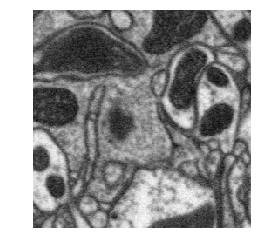

In [5]:
# image to numpy array
im = Image.open("./datasets/grayscale_maps/iso.2600.png", 'r')

array = np.asarray(im)

plt.imshow(array, cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# Having a stack of images as a numpy array
original_dataset_dir = "./datasets/grayscale_maps/"

fnames = [original_dataset_dir + 'iso.{}.png'.format(i) for i in range(2600, 2850)]

dst = np.zeros((250, 250, 250))

for i, fname in enumerate(fnames):
    src = os.path.join(original_dataset_dir, fname)
    image = Image.open(fname, 'r')
    array = np.asarray(image)
    dst[:, :, i] += array    

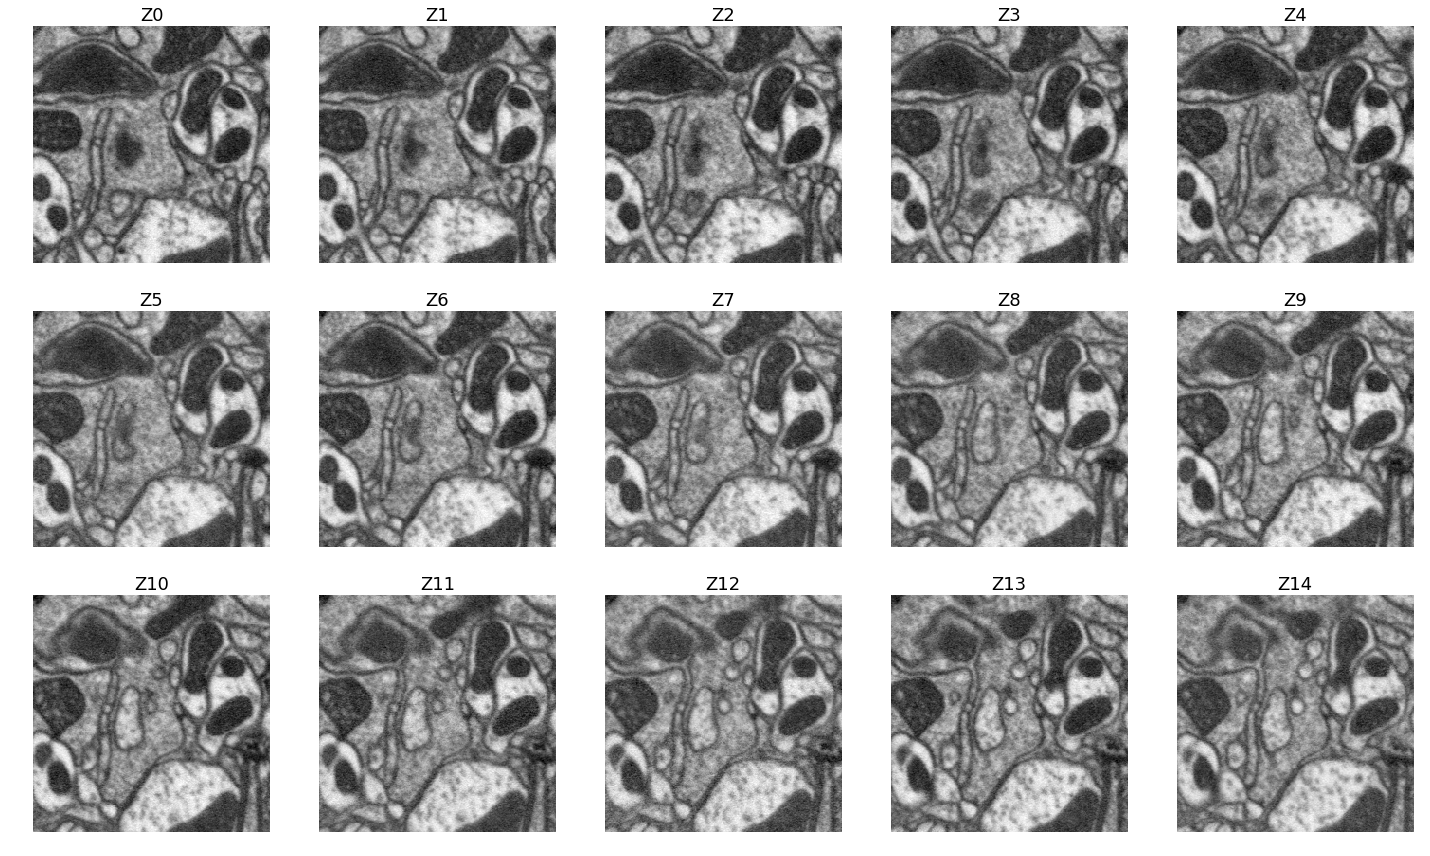

In [7]:
# Plotting several images from the array
plt.figure(figsize=(20, 12))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(dst[:, :, i], cmap='gray')
    plt.axis('off')
    plt.title('Z{}'.format(i), fontsize=18)
    
plt.tight_layout()
plt.show()

In [8]:
h5 = h5py.File('./datasets/groundtruth.h5', 'r')
print(h5['stack'].shape)
print(h5['transforms'].shape) # What?

(250, 250, 250)
(21317, 2)


In [66]:
transforms = h5['transforms'].value
gt = h5['stack'].value
gt = np.swapaxes(gt, 0, 2)# ht['stack'].shape = (Z, Y, X)
uniq = np.unique(gt)

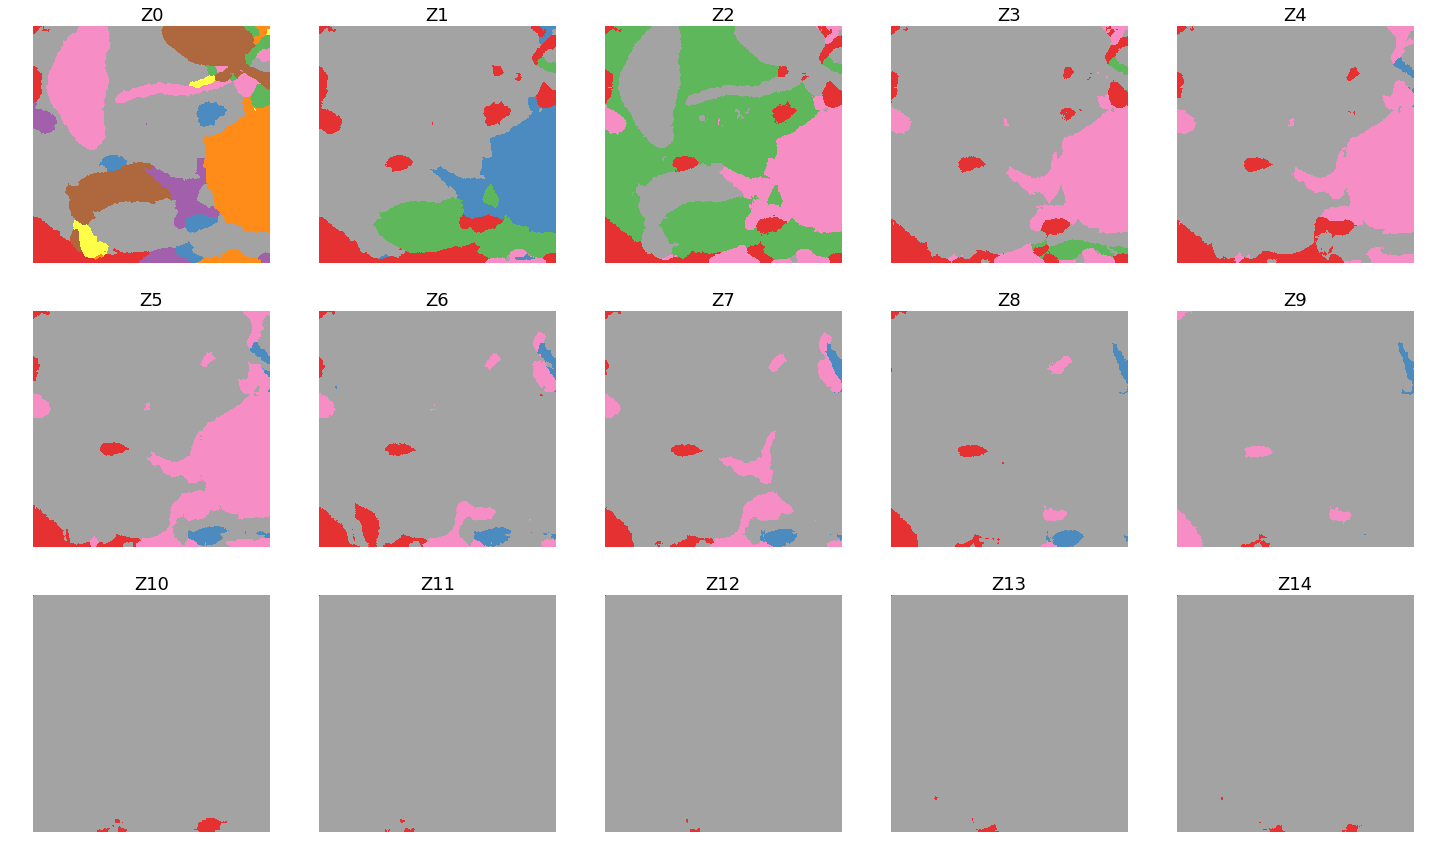

In [67]:
# Plotting several images from the array
plt.figure(figsize=(20, 12))

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(gt[:, :, i], cmap=plt.cm.get_cmap('Set1'), alpha=0.9)
    plt.axis('off')
    plt.title('Z{}'.format(i), fontsize=18)
    
plt.tight_layout()
plt.show()